In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import math
from typing import List

In [3]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torchtext.datasets import Multi30k

# setting and preprocessing

In [4]:
SRC_LANGUAGE = 'de'
TRG_LANGUAGE = 'en'

In [5]:
token_transform = {
    'de': get_tokenizer('spacy',language='de_core_news_sm'),
    'en': get_tokenizer('spacy',language='en_core_web_sm')
}

In [6]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_tokens = ['<unk>', '<pad>', '<bos>', '<eos>']

In [7]:
def iter_func(dataset, lang: str) -> List[str]:
    for i in dataset:
        yield token_transform[lang](i[0 if lang==SRC_LANGUAGE else 1])

In [8]:
vocab_transform = {
    'de': '',
    'en': ''
}

In [9]:
for l in vocab_transform:

    train_iter = Multi30k(split='train')
    
    vocab_transform[l] = build_vocab_from_iterator(iter_func(train_iter,l), 
                                                  specials=special_tokens,
                                                  special_first=True)
    
    vocab_transform[l].set_default_index(UNK_IDX)

In [10]:
# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat([torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])])

In [11]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

In [12]:
# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {
    'de': sequential_transforms(token_transform[SRC_LANGUAGE],vocab_transform[SRC_LANGUAGE], tensor_transform),
    'en': sequential_transforms(token_transform[TRG_LANGUAGE],vocab_transform[TRG_LANGUAGE], tensor_transform)
}

In [19]:
# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TRG_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

# Model

In [14]:
class Encoder(nn.Module):
    """
    將欲翻譯句子轉為隱向量
    """
    
    def __init__(self, embed_dim = 128):
        super(Encoder,self).__init__()
        self.embed_dim = embed_dim
        self.hidden_dim = embed_dim
        
        self.embed = nn.Embedding(len(vocab_transform[SRC_LANGUAGE]),embed_dim)
        self.rnn = nn.LSTM(embed_dim,self.hidden_dim,1)
    
    def forward(self, x):
        tmp = self.embed(x)
        o, (ht, ct) = self.rnn(tmp)
        return ht, ct

In [15]:
class Decoder(nn.Module):
    """
    將隱向量與目標句子轉為欲翻譯句子
    """
    
    def __init__(self, embed_dim = 128):
        super(Decoder,self).__init__()
        self.embed_dim = embed_dim
        self.hidden_dim = embed_dim
        self.output_dim = len(vocab_transform[TRG_LANGUAGE])
        
        self.embed = nn.Embedding(self.output_dim,embed_dim)
        self.rnn = nn.LSTM(embed_dim,self.hidden_dim,1)
        self.fc = nn.Linear(self.hidden_dim,self.output_dim)
    
    def forward(self, x, h, c):
        tmp = x.unsqueeze(0)
        tmp = self.embed(tmp)
        o, (h, c) = self.rnn(tmp, (h, c))
        o = o.squeeze(0)
        o = self.fc(o)
        return o, h, c

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        trg_len, batch_size = trg.shape
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.full((trg_len, batch_size, trg_vocab_size), float(BOS_IDX)).cuda()
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input_seq = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, _, _ = self.decoder(input_seq, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input_seq = trg[t] if teacher_force else top1
        
        return outputs

In [121]:
enc = Encoder().cuda()
dec = Decoder().cuda()
model = Seq2Seq(enc,dec).cuda()

In [122]:
## 測試 forward
for s,t in trainloader:
    s,t = s.cuda(), t.cuda()
    output = model(s,t)
    print(output.shape)
    break

torch.Size([24, 32, 10838])


# Training

In [21]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
optim = torch.optim.Adam(model.parameters())

In [124]:
epoches = 10

In [125]:
model.train()
training_loss = []
for e in range(epoches):
    running_loss = 0.0
    
    train_iter = Multi30k(split='train')
    trainloader = DataLoader(train_iter, batch_size=32, collate_fn=collate_fn)
    
    for s,t in tqdm(trainloader):
        text = s.cuda()
        label = t.cuda()
        
        output = model(text,label)
        
        output = output[1:].view(-1, output.shape[-1])
        label = label[1:].view(-1)
        
        optim.zero_grad()
        loss = criterion(output,label)
        loss.backward()
        optim.step()
        
        running_loss += loss.item()
    training_loss.append(running_loss/len(train))
    print(f'epoch {e+1} : {running_loss/len(train)}')

  0%|▏                                                                                 | 2/907 [00:00<00:58, 15.43it/s]

epoch 1 : 0.1607525174535554


  0%|▏                                                                                 | 2/907 [00:00<00:57, 15.67it/s]

epoch 2 : 0.14542219115947855


  0%|▏                                                                                 | 2/907 [00:00<00:55, 16.44it/s]

epoch 3 : 0.13578977411368798


  0%|▏                                                                                 | 2/907 [00:00<00:57, 15.79it/s]

epoch 4 : 0.12786224468823137


  0%|▏                                                                                 | 2/907 [00:00<00:55, 16.30it/s]

epoch 5 : 0.12155147397107091


  0%|▏                                                                                 | 2/907 [00:00<00:55, 16.30it/s]

epoch 6 : 0.11617290838833513


  0%|▏                                                                                 | 2/907 [00:00<00:55, 16.17it/s]

epoch 7 : 0.11218528918562264


  0%|▏                                                                                 | 2/907 [00:00<00:57, 15.79it/s]

epoch 8 : 0.10831787346971446


  0%|▏                                                                                 | 2/907 [00:00<00:57, 15.67it/s]

epoch 9 : 0.10448978164278228


100%|████████████████████████████████████████████████████████████████████████████████| 907/907 [01:04<00:00, 14.00it/s]

epoch 10 : 0.10110897660255432


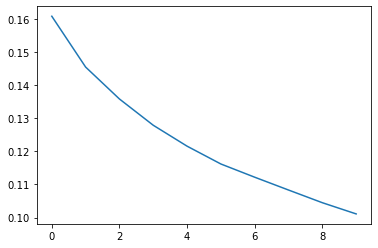

In [126]:
plt.plot(training_loss)

# Evaluate

In [22]:
model.eval()
running_loss = 0.0
with torch.no_grad():
    test_iter = Multi30k(split='test')
    testloader = DataLoader(test_iter, batch_size=32, collate_fn=collate_fn)
    
    for s, t in tqdm(testloader):
        text, label = s.cuda(), t.cuda()
        
        output = model(text, label, 0)
        output = output[1:].view(-1, output.shape[-1])
        label = label[1:].view(-1)
        loss = criterion(output,label)
        
        running_loss += loss.item()
    final_loss = running_loss/len(test_iter)
print(f'loss: {final_loss}')
print(f'perplexity: {math.exp(final_loss)}')

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 34.81it/s]

loss: 0.14418118381500244
perplexity: 1.155093373790749


# Translate

In [23]:
MAX_LENGTH = 100

model.eval()
with torch.no_grad():
    test_iter = Multi30k(split='test')
    trg_vocab_size = len(vocab_transform[TRG_LANGUAGE])
    
    for i, (s, _) in enumerate(test_iter):
        ori_text = s
        s = text_transform[SRC_LANGUAGE](s.rstrip())
        s = s.unsqueeze(1)
        s = s.cuda()
        
        outputs = [BOS_IDX]
        
        h, c = model.encoder(s)
        
        for _ in range(MAX_LENGTH):
            
            input_seq = torch.LongTensor([outputs[-1]]).cuda()
            
            output, _, _ = model.decoder(input_seq, h, c)
            
            next_token = output.argmax(1).item()
            outputs.append(next_token) 
            
            if next_token == EOS_IDX: break
        
        if EOS_IDX in outputs:
            translated = vocab_transform[TRG_LANGUAGE].lookup_tokens(outputs[1:-2])
            print(f'第{i+1}句')
            print(ori_text.rstrip())
            print(*translated,sep=' ')
        
        if i==100: break

第1句
Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.
A man in a orange hat is eating something
第4句
Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.
Five people are standing in the background
第5句
Leute Reparieren das Dach eines Hauses.
People are working on the roof of a building
第7句
Eine Gruppe von Menschen steht vor einem Iglu.
A group of people standing outside a building
第10句
Ein Mann in einer Weste sitzt auf einem Stuhl und hält Magazine.
A man in a chair
第12句
Männer, die Volleyball spielen, wobei ein Mann denn Ball nicht trifft während seine Hände immer noch in der Luft sind.
Men in the air
第13句
Eine Frau, die in einer Küche eine Schale mit Essen hält.
A woman holding a hand
第15句
Drei Leute sitzen in einer Höhle.
Three people sit on a park
第21句
Leute, die vor einem Gebäude stehen.
People standing in front of a building
第24句
Ein Mann steht bei einigen Spielautomaten in einer Bar.
A man is standing at a
第28句
Eine Gruppe Asiatisch

# SL

In [160]:
torch.save(model,'seq2seq.pth')

In [17]:
model = torch.load('seq2seq.pth')